# Getting Your Data From Yelp!

## Part 2 - Create ETL pipeline for the business data from the API

Now that you know what data you need from the API, you want to write code that will execute a api call, parse those results and then insert the results into the DB.  

It is helpful to break this up into three different functions (*api call, parse results, and insert into DB*) and then you can write a function/script that pull the other three functions together. 

Let's first do this for the Business endpoint.

- Write a function to make a call to the yelp API

In [1169]:
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings

url = 'https://api.yelp.com/v3/businesses/search'
api_key = "S3cROVIGs17gTiCO6iy8-2ycbL999zhz84ANxStc2mYNESu0cKfM4qdarKNZ69t-2bnTPSR_RRTTCTKmpQidQYhD1mpVN1zvyo0EGTVthI7SVumcOA3IZrRgj5omYHYx"
headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }

# what type of business do you want to search
term = 'Thai'
term2 = 'Mexican'
#where do you want to perform this search
location = 'NYC'

# what is your other parameter you want to search against
categories = 'restaurants'
url_params = {
                "term": term.replace(' ', '+'),
                "location": location.replace(' ', '+'),
                "categories" : categories,
                "limit": 50,
                "offset": None
    
            }
url_params2 = {
                "term": term2.replace(' ', '+'),
                "location": location.replace(' ', '+'),
                "categories" : categories,
                "limit": 50,
                "offset": None
            }

In [843]:

def yelp_call(url_params):
    
    response = requests.get(url, headers=headers, params=url_params)
    return response.json()['total']
    

- Write a function to parse the API response so that you can easily insert the data in to the DB

In [133]:
def parse_results(list_of_data):
    # create a container to hold our parsed data
    biz_list = []
    # loop through our business and 
    for business in list_of_data:
    # parse each individual business into a tuple
    #parseing out transactions
        if 'pickup'in business['transactions']:
            business['pickup'] = True
        else:
            business['pickup'] = False
        if 'delivery' in business['transactions']:
            business['delivery'] = True
        else:
            business['delivery'] = False
        if 'restaurant_reservation' in business['transactions']:
            business['restaurant_reservation'] = True
        else:
            business['restaurant_reservation'] = False
    
    #checking if price is there
        if 'price' not in business:
            business['price'] = np.nan
        biz_tuple = (business['id'],
                     business['name'],
                     business['location']['address1'],
                     business['rating'],
                     business['price'],
                     business['location']['zip_code'],
                     business['pickup'],
                     business['delivery'],
                     business['restaurant_reservation'],
                     business['review_count'],
                     business['categories'],
                     business['is_closed'])   
    # add each individual business tuple to our data container
        biz_list.append(biz_tuple)
    # return the container with all of the parsed results
    return biz_list

- Write a function to take your parsed data and add it to the csv file where you will store all of your results. 

In [152]:
def df_save(csv_file_path, parsed_results):
    # your code to open the csv file, concat the current data, and save the data. 
    business_df = pd.DataFrame(parsed_results, columns = ['Id','Name', 'Location', 'Rating', 'Price', 'Zipcode', 'Pickup', 'Delivery', 'Reservation', 'Review Count', 'Categories','Status'])
    x = business_df.to_csv(csv_file_path, mode = 'a')
#     new_df = pd.read_csv(csv_file_path, delimiter = ",")
    return x
#     pd.DataFrame(parsed_results).to_csv()

In [1166]:
from functions import *

- Write a script that combines the three functions above into a single process.

While it will take some experimentation to write the functions above, once you get them working it will be best to put them in a `.py` file and then import the functions to use in a script 

In [163]:
#SCRIPT FOR THAI

# create a variable  to keep track of which result you are in. 
cur = 0
url_params['offset']=0

#set up a while loop to go through and grab the result 
while cur < 500 :
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = cur
    print(cur)
    #make your API call with the new offset number
    results = yelp_call(url_params)
    
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results(results)
    # use your function to insert your parsed results into the db
    df_save('thaii.csv', parsed_results)
    #increment the counter by 50 to move on to the next results
    cur += 50
    

0
50
100
150
200
250
300
350
400
450


In [173]:
#SCRIPT FOR MEXICAN

# create a variable  to keep track of which result you are in. 
cur = 0
url_params2['offset']=0

#set up a while loop to go through and grab the result 
while cur < 500 :
    #set the offset parameter to be where you currently are in the results 
    url_params2['offset'] = cur
    print(cur)
    #make your API call with the new offset number
    results_mex = yelp_call(url_params2)
    
    #after you get your results you can now use your function to parse those results
    parsed_results_mex = parse_results(results_mex)
    # use your function to insert your parsed results into the db
    df_save('mexx.csv', parsed_results_mex)
    #increment the counter by 50 to move on to the next results
    cur += 50

0
50
100
150
200
250
300
350
400
450


In [1028]:
thaidf = pd.read_csv('thaii.csv')

In [1029]:
mexdf = pd.read_csv('mexx.csv')

## Part 3 -  Create ETL pipeline for the restaurant review data from the API

You've done this for the Businesses, now you need to do this for reviews. You will follow the same process, but your functions will be specific to reviews. Above you ahve a model of the functions you will need to write, and how to pull them together in one script. For this part, you have the process below 

- In order to pull the reveiws, you will need the business ids. So your first step will be to get all of the business ids from your businesses csv. 

In [398]:
response = requests.get(url, headers=headers, params=url_params)
response.status_code

200

- Write a function that takes a business id and makes a call to the API for reivews


In [365]:
headers = {'Authorization': 'Bearer {}'.format(api_key)}
categories = 'restaurants'
url_params_rev = {"limit": 50}





In [394]:
def yelp_call_rev(url_params, given_df):
    responses=[]
    for business in list(given_df['Id']):
        url = 'https://api.yelp.com/v3/businesses/{}/reviews'.format(business)
        try:
            response = requests.get(url, headers=headers)
            responses.append((response.json()['reviews'],business))
        except:
            continue
    return responses


In [387]:
def parse_results_review(list_of_data, given_df):
    review_list = []
    for l in yelp_call_rev(url_params, given_df):
        for review in l:
            for t in review:
#             print (t)
                try:
                    review_tuple = (l[1],
                            t['id'],
                            t['text'],
                            t['rating'],
                            t['time_created'])   
    # add each individual business tuple to our data container
                    review_list.append(review_tuple)
                except:
                    break
    # return the container with all of the parsed results
    return review_list

- Write a function to parse out the relevant information from the reviews

- Write a function to save the parse data into a csv file containing all of the reviews. 

In [223]:
def df_save_review(csv_file_path, parsed_results):
    # your code to open the csv file, concat the current data, and save the data. 
    business_df = pd.DataFrame(parsed_results, columns = ['Business ID','ID', 'Review', 'Rating', 'Date'])
    business_df.to_csv(csv_file_path, mode = 'a')
    new_df = pd.read_csv(csv_file_path, delimiter = ",") #delte this later
    return new_df

- Combine the functions above into a single script  

In [395]:
#THAI REVIEWS SCRIPT

thai_yelpcall = yelp_call_rev(url_params, thaidf)
thai_parsed_results = parse_results_review(thai_yelpcall, thaidf)
df_save_review('thaireview.csv', thai_parsed_results)    


,Unnamed: 0,Business ID,ID,Review,Rating,Date
0,0,uazg6WhYVOw3jhWCG_MDBg,eoqQ6cSoPLOd7YWAjWNS4A,"Sadly due to Covid 19 disaster , we avoid eati...",5,2020-12-25 15:29:31
1,1,uazg6WhYVOw3jhWCG_MDBg,jth1qrL_taRqkxNe0r5xSw,Sup Thai Kitchen was recommended by our friend...,5,2020-11-14 18:27:22
2,2,uazg6WhYVOw3jhWCG_MDBg,qZbZ7qQ8omuIMgq-Ju5adA,Sup means treasure/asset in Thai and this re...,5,2020-11-08 17:15:23
3,3,cegA4jf16vEt7NCQ7cpu2w,0by1FawYnfJSonyQW3QSLQ,I'm so glad to see this business open and doin...,5,2021-01-10 13:34:52
4,4,cegA4jf16vEt7NCQ7cpu2w,rKMbqLwkCBIuh6KXE7jxlA,I have been ordering from here via Uber eats d...,5,2021-01-05 03:06:27
...,...,...,...,...,...,...
1462,1462,RwEs6AvU5Cxp_ENodsgxHw,mXeQURpQd1FL_uqsAWD7Ow,Amazing food! Ordered take out after passing a...,5,2020-06-26 17:57:52
1463,1463,RwEs6AvU5Cxp_ENodsgxHw,dNDtsftreJJS-hdi2z9_hw,I ordered delivery through Door Dash.. so it g...,4,2020-07-13 06:49:56
1464,1464,B9_TgZa8rgW5oZOtXZUMCw,yHgjVJ4g9stpWAFUdBno0A,TL:DR; this laksa slaps and and is the best I'...,5,2020-12-12 09:43:22
1465,1465,B9_TgZa8rgW5oZOtXZUMCw,fl41eNAD1dyuTHwFZAPspw,"Southeast Asian food is a favorite, but if I h...",4,2020-11-20 09:27:24


In [399]:
#MEXICAN REVIEWS SCRIPT

mex_yelpcall = yelp_call_rev(url_params, mexdf)
    
mex_parsed_results=parse_results_review(mex_yelpcall, mexdf)
  
df_save_review('mexreview.csv',mex_parsed_results)

,Unnamed: 0,Business ID,ID,Review,Rating,Date
0,0,7YYp_2WYWdRSt_NohV7Psw,kfThRpF-hjfWjwyPgSAYRw,Must try: Three Tacos Combo and Consomé!\n\nWh...,5,2021-01-18 07:21:31
1,1,7YYp_2WYWdRSt_NohV7Psw,jxOA8wOzDGbi9BNq7h47iw,If you're looking for birria tacos but don't w...,4,2021-02-03 08:34:45
2,2,7YYp_2WYWdRSt_NohV7Psw,53j_6H_eTJztLGtSZrmeew,Conveniently located off the 4/5! Very clean a...,4,2021-01-06 14:34:46
3,3,6Ct7OeTRn4caY9g0swFBsw,f5EIfn9lcPaOG20gw3j0dQ,Please go support this restaurant! They have c...,5,2021-01-14 09:56:09
4,4,6Ct7OeTRn4caY9g0swFBsw,z6F-ZmAyH8_hN5rTciqDzA,Small little hole in the wall place with big f...,5,2020-09-30 02:35:05
...,...,...,...,...,...,...
1482,1482,s3Zs6FNW-FUTA3ODWOFVsA,pT7hLq8QejWdum-YtPSZhg,OPEN DURING COVID SHELTER-n-PLACE \n\nFirst of...,5,2020-05-05 16:27:02
1483,1483,s3Zs6FNW-FUTA3ODWOFVsA,9JnuQJlyM0Jn7I_s0zVz5w,I was waiting in line at DiFara's (as you do) ...,5,2020-01-12 07:25:21
1484,1484,60sLpAHHl-IvANGTRzfCow,80GekwTZeQvJa2yV8xtkvg,The plates are average in size but filling. Th...,5,2021-02-13 10:30:47
1485,1485,60sLpAHHl-IvANGTRzfCow,SyFohkvyBC-ERPyOeFrkMQ,No-frills solid Mexican spot in an area that d...,4,2021-01-14 15:38:27


In [1024]:
thai_rev_df=pd.read_csv('thaireview.csv')
mex_rev_df=pd.read_csv('mexreview.csv')


In [1030]:
thaidf['type']='Thai'
mexdf['type']='Mexican'

___

## Part 4 -  Using python and pandas, write code to answer the questions below. 


- Which are the 5 most reviewed businesses in your dataset?
- What is the highest rating recieved in your data set and how many businesses have that rating?
- What percentage of businesses have a rating greater than or  4.5?
- What percentage of businesses have a rating less than 3?
- What percentage of your businesseshave a price label of one dollar sign? Two dollar signs? Three dollar signs? No dollar signs?
- Return the text of the reviews for the most reviewed business. 
- Find the highest rated business and return text of the most recent review. If multiple business have the same rating, select the business with the most reviews. 
- Find the lowest rated business and return text of the most recent review.  If multiple business have the same rating, select the business with the least reviews. 


In [1032]:
df=pd.concat([thaidf,mexdf])
df_review=pd.concat([thai_rev_df,mex_rev_df])
df=df.set_index('Id')
df_review=df_review.set_index('ID')

In [1033]:
#had duplicate indicies so dropped that column
df=df.drop(df.columns[0], axis=1)
df_review=df_review.drop(df_review.columns[0],axis=1)

In [1035]:
#had headers in place of data so removed those rows
df = df[df['Rating']!='Rating']

In [1036]:
#review count was object type so converted to int to sort
df['Review Count']=df['Review Count'].astype(int)
df['Rating']=df['Rating'].astype(float)
df['Price']=df['Price'].astype('string')

thaidf=thaidf[thaidf['Rating']!='Rating']
thaidf['Rating']=thaidf['Rating'].astype(float)
mexdf=mexdf[mexdf['Rating']!='Rating']
mexdf['Rating']=mexdf['Rating'].astype(float)



<ipython-input-1036-c00468c62430>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review Count']=df['Review Count'].astype(int)
<ipython-input-1036-c00468c62430>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rating']=df['Rating'].astype(float)
<ipython-input-1036-c00468c62430>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [1039]:
#converted all dates to datetime object in order to sort by date

from datetime import datetime
def convert_dt(string):
    date_time_obj=datetime.strptime(string, '%Y-%m-%d %H:%M:%S' )
    return date_time_obj
df_review['Date'].map(convert_dt)

ID
eoqQ6cSoPLOd7YWAjWNS4A   2020-12-25 15:29:31
jth1qrL_taRqkxNe0r5xSw   2020-11-14 18:27:22
qZbZ7qQ8omuIMgq-Ju5adA   2020-11-08 17:15:23
0by1FawYnfJSonyQW3QSLQ   2021-01-10 13:34:52
rKMbqLwkCBIuh6KXE7jxlA   2021-01-05 03:06:27
                                 ...        
pT7hLq8QejWdum-YtPSZhg   2020-05-05 16:27:02
9JnuQJlyM0Jn7I_s0zVz5w   2020-01-12 07:25:21
80GekwTZeQvJa2yV8xtkvg   2021-02-13 10:30:47
SyFohkvyBC-ERPyOeFrkMQ   2021-01-14 15:38:27
AqwpDVJxDDljH9iooX7dxQ   2020-08-01 13:28:10
Name: Date, Length: 2954, dtype: datetime64[ns]

In [1040]:
df_review = df_review.sort_values(by='Date',ascending=False)

In [1041]:
#trying to convert price to int 

def convert_to_len(obj):
    if obj=='0':
        return 0
    else:
        return len(obj)
    
    
thaidf['Price'] = thaidf['Price'].fillna('0')
    
thaidf['Price'] = thaidf['Price'].map(convert_to_len)
thaidf['Price'].value_counts()

mexdf['Price'] = mexdf['Price'].fillna('0')
    
mexdf['Price'] = mexdf['Price'].map(convert_to_len)
mexdf['Price'].value_counts()

2    266
1    128
0     99
3      7
Name: Price, dtype: int64

PANDAS QUESTIONS

In [1042]:
#TOP 5 REVIEWS
top_5_reviews=df.sort_values('Review Count',ascending=False)[0:5]
top_5_reviews

,Name,Location,Rating,Price,Zipcode,Pickup,Delivery,Reservation,Review Count,Categories,Status,type
Id,,,,,,,,,,,,
jjJc_CrkB2HodEinB6cWww,LoveMama,174 2nd Ave,4.5,$$,10003,True,True,False,5198,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':...",False,Thai
B3_K2kUVbYOU0VaLcj_LTw,Thai Villa,5 E 19th St,4.5,$$,10003,True,True,False,3549,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':...",False,Thai
NOh24SMS6k4pzNv8Ds7KDg,Cafe Habana,17 Prince St,4.0,$$,10012,True,True,False,3157,"[{'alias': 'cuban', 'title': 'Cuban'}, {'alias...",False,Mexican
QVWmn5jmy_TPmg0G71Dk5g,Sea,114 N 6th St,3.5,$$,11211,True,True,False,3140,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':...",False,Thai
jnEv25Y2DosTq2sNnvmC9g,Los Tacos No.1,75 9th Ave,4.5,$,10011,False,False,False,3068,"[{'alias': 'tacos', 'title': 'Tacos'}]",False,Mexican


In [1043]:
#HIGHEST RATED/ 5 businesses have 5.0 rating
highest_rated=df.sort_values('Rating',ascending=False)[0:10]

In [1044]:
#RATINGS GREATER THAN OR EQUAL TO 4.5
high_ratings_perc=(len(df[df['Rating']>=4.5])/len(df))*100

In [1045]:
#RATINGS LOWER THAN 3.0
low_ratings_perc=(len(df[df['Rating']<3])/len(df))*100
low_ratings_perc

0.7000000000000001

In [1046]:
#VALUE COUNTS FOR PRICE DOLLAR SIGNS
df['Price'].value_counts()

$$      635
$       161
$$$       7
$$$$      1
Name: Price, dtype: Int64

In [1013]:
#RETURN TEXT OF REVIEW FOR MOST REVIEWED
most_reviews=df[df['Review Count']==df['Review Count'].max()]

x=df_review['Review'][(df_review['Business ID'].isin(most_reviews.index))].to_string().split('\n')
x


['ID',
 'pWWqEQb86iGs7gYoML3thw    my friends and i were all craving different fo...',
 'CWFwiYEkzHvb2fuDFTAupA    I was in NYC on Christmas Day and we were sear...',
 'yrCJUsjsXzIwNBALVCz3EA    Came back yesterday after 3 years!!! Sorry I w...']

In [1014]:
#Find the highest rated business and return text of the most recent review
most_rated_reviews=df[df['Rating']==df['Rating'].max()]

review_rating= most_rated_reviews[most_rated_reviews['Review Count']==most_rated_reviews['Review Count'].max()]
review_rating

z=df_review['Review'][(df_review['Business ID'].isin(review_rating.index))]
highest_recent_text = z[0]

In [1015]:
#Find the lowest rated business and return text of the most recent review

least_rated_reviews=df[df['Rating']==df['Rating'].min()]

review_low_rating= least_rated_reviews[least_rated_reviews['Review Count']==least_rated_reviews['Review Count'].min()]

review_low_rating


d=df_review['Review'][(df_review['Business ID'].isin(review_low_rating.index))]

lowest_rated= d[0]


#### VISUALS

In [1110]:
sns.set_style('darkgrid')
sns.set_theme()

(1.0, 6.0)

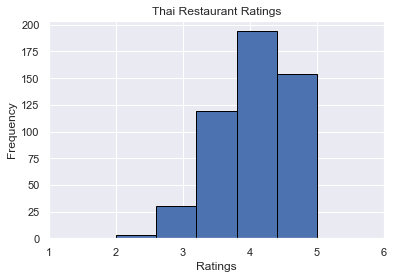

In [1106]:
thaidf
fig,ax=plt.subplots()
ax.hist(thaidf['Rating'],edgecolor='black',bins=5)
ax.set_title('Thai Restaurant Ratings')
ax.set_xlabel('Ratings')
ax.set_ylabel('Frequency')
ax.set_xlim(1.0,6.0)

(1.0, 6.0)

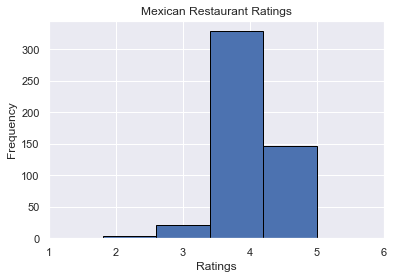

In [1107]:
fig,ax=plt.subplots()
ax.hist(mexdf['Rating'],edgecolor='black',bins=5)
ax.set_title('Mexican Restaurant Ratings')
ax.set_xlabel('Ratings')
ax.set_ylabel('Frequency')
ax.set_xlim(1.0,6.0)

(-0.5, 5.0)

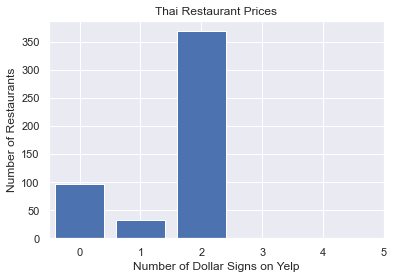

In [1108]:
#looking at price for mex vs price for thai

x=thaidf['Price'].value_counts().sort_index().index
y= thaidf.groupby('Price')['Price'].count()
fig,ax=plt.subplots()
plt.bar(x,y)
ax.set_title('Thai Restaurant Prices')
ax.set_xlabel('Number of Dollar Signs on Yelp')
ax.set_ylabel('Number of Restaurants')
ax.set_xlim(-.5,5)

# ax.set_xticks([0,1,2,3,4])    
# ax.set_xticklabels(['N/A','$','$$','$$$','$$$$'])
# ax.set_xticklabels(['not provided','cheap','not cheap','expen','very expen'])



In [1050]:
mexdf['Price'].value_counts()

2    266
1    128
0     99
3      7
Name: Price, dtype: int64

(-0.5, 5.0)

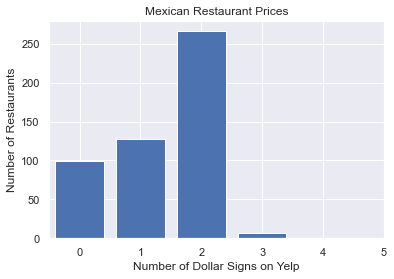

In [1111]:
#looking at price for mex vs price for thai

a=mexdf['Price'].value_counts().sort_index().index
b= mexdf.groupby('Price')['Price'].count()
fig2,ax2=plt.subplots()
plt.bar(a,b)
ax2.set_title('Mexican Restaurant Prices')
ax2.set_xlabel('Number of Dollar Signs on Yelp')
ax2.set_ylabel('Number of Restaurants')
ax2.set_xlim(-.5,5)


In [1167]:
def rest_services_visual():
    thai_pickup = thaidf[thaidf['Pickup']=='True'].count()['Name']
    thai_delivery = thaidf[thaidf['Delivery']=='True'].count()['Name']
    thai_reservation = thaidf[thaidf['Reservation']=='True'].count()['Name']

    mex_pickup = mexdf[mexdf['Pickup']=='True'].count()['Name']
    mex_delivery = mexdf[mexdf['Delivery']=='True'].count()['Name']
    mex_reservation = mexdf[mexdf['Reservation']=='True'].count()['Name']

    N = 3
    thai_bar = (thai_pickup, thai_delivery, thai_reservation)
    mex_bar = (mex_pickup, mex_delivery, mex_reservation)

    # # Position of bars on x-axis
    ind = np.arange(N)
    figure,axes=plt.subplots(figsize=(9,5))
    width = 0.3       

    plt.bar(ind, thai_bar , width, label= 'Thai Services')
    plt.bar(ind + width, mex_bar, width, label='Mexican Services')

    axes.set_xlabel('Restaurant Services')
    axes.set_ylabel('Number')
    axes.set_title('Thai vs. Mexican Services')

    # xticks()
    # First argument - A list of positions at which ticks should be placed
    # Second argument -  A list of labels to place at the given locations
    axes.set_xticks(ind + width/ 2, ('Pickup', 'Delivery', 'Reservation'))
    axes.set_xticklabels(['','Pickup','', 'Delivery','', 'Reservation'])

    # Finding the best position for legends and putting it
    plt.legend(loc='best')
    return plt.show()


<ipython-input-1167-4e121b937001>:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes.set_xticks(ind + width/ 2, ('Pickup', 'Delivery', 'Reservation'))
<ipython-input-1167-4e121b937001>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['','Pickup','', 'Delivery','', 'Reservation'])


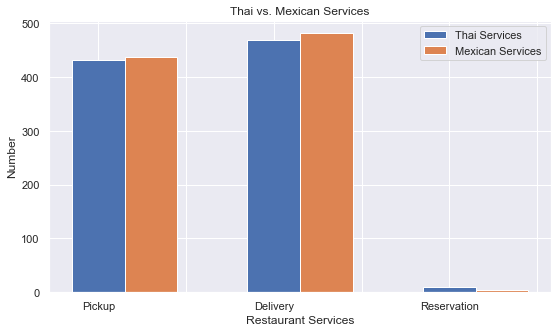

In [1168]:
rest_services_visual()

<ipython-input-1144-d764974688c5>:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes.set_xticks(ind + width/ 2, ('Pickup', 'Delivery', 'Reservation'))
<ipython-input-1144-d764974688c5>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['','Pickup','', 'Delivery','', 'Reservation'])


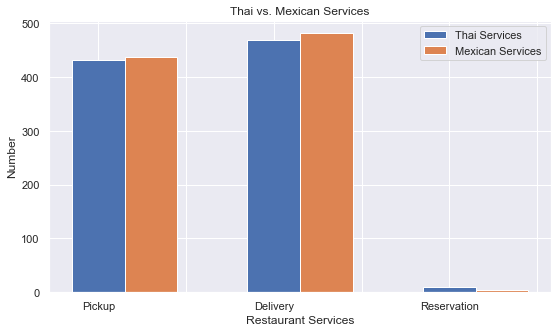

In [1144]:
thai_pickup = thaidf[thaidf['Pickup']=='True'].count()['Name']
thai_delivery = thaidf[thaidf['Delivery']=='True'].count()['Name']
thai_reservation = thaidf[thaidf['Reservation']=='True'].count()['Name']

mex_pickup = mexdf[mexdf['Pickup']=='True'].count()['Name']
mex_delivery = mexdf[mexdf['Delivery']=='True'].count()['Name']
mex_reservation = mexdf[mexdf['Reservation']=='True'].count()['Name']

N = 3
thai_bar = (thai_pickup, thai_delivery, thai_reservation)
mex_bar = (mex_pickup, mex_delivery, mex_reservation)

# # Position of bars on x-axis
ind = np.arange(N)
figure,axes=plt.subplots(figsize=(9,5))

width = 0.3       

plt.bar(ind, thai_bar , width, label= 'Thai Services')
plt.bar(ind + width, mex_bar, width, label='Mexican Services')

axes.set_xlabel('Restaurant Services')
axes.set_ylabel('Number')
axes.set_title('Thai vs. Mexican Services')

# # xticks()
# # First argument - A list of positions at which ticks should be placed
# # Second argument -  A list of labels to place at the given locations
axes.set_xticks(ind + width/ 2, ('Pickup', 'Delivery', 'Reservation'))
axes.set_xticklabels(['','Pickup','', 'Delivery','', 'Reservation'])

# # Finding the best position for legends and putting it
plt.legend(loc='best')

# plt.savefig('RestServices.jpeg')


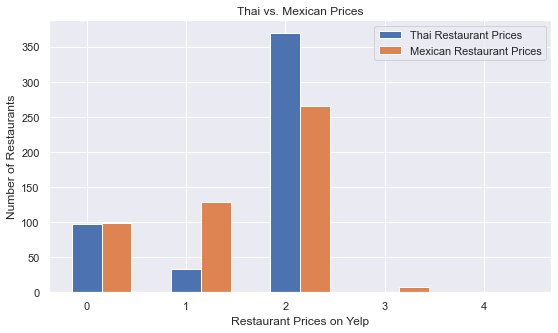

In [1142]:
thai_price_0 = thaidf[thaidf['Price'] == 0].count()['Name']
thai_price_1 = thaidf[thaidf['Price'] == 1].count()['Name']
thai_price_2 = thaidf[thaidf['Price'] == 2].count()['Name']
thai_price_3 = thaidf[thaidf['Price'] == 3].count()['Name']
thai_price_4 = thaidf[thaidf['Price'] == 4].count()['Name']

mex_price_0 = mexdf[mexdf['Price'] == 0].count()['Name']
mex_price_1 = mexdf[mexdf['Price'] == 1].count()['Name']
mex_price_2 = mexdf[mexdf['Price'] == 2].count()['Name']
mex_price_3 = mexdf[mexdf['Price'] == 3].count()['Name']
mex_price_4 = mexdf[mexdf['Price'] == 4].count()['Name']

N = 5
thai_price = (thai_price_0, thai_price_1, thai_price_2, thai_price_3, thai_price_4)
mex_price = (mex_price_0, mex_price_1, mex_price_2, mex_price_3, mex_price_4)

# # Position of bars on x-axis
ind = np.arange(N)
figure,axes=plt.subplots(figsize=(9,5))

width = 0.3       

plt.bar(ind, thai_price , width, label= 'Thai Restaurant Prices')
plt.bar(ind + width, mex_price, width, label='Mexican Restaurant Prices')

axes.set_xlabel('Restaurant Prices on Yelp')
axes.set_ylabel('Number of Restaurants')
axes.set_title('Thai vs. Mexican Prices')

# # xticks()
# # First argument - A list of positions at which ticks should be placed
# # Second argument -  A list of labels to place at the given locations
# axes.set_xticks(ind + width/ 2, ('Pickup', 'Delivery', 'Reservation'))
# axes.set_xticklabels(['','Not given','', 'One dollar sign','', 'Two dollar sign', '', 'Three dollar sign','','Four dollar sign'])

# # Finding the best position for legends and putting it
plt.legend(loc='best')
plt.savefig('RestPrice.jpeg')


In [1116]:
df['Zipcode']=df['Zipcode'].astype(int)
# df.groupby('Zipcode')['Zipcode'].value_counts().describe()

<ipython-input-1116-7e1356bf1abd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Zipcode']=df['Zipcode'].astype(int)


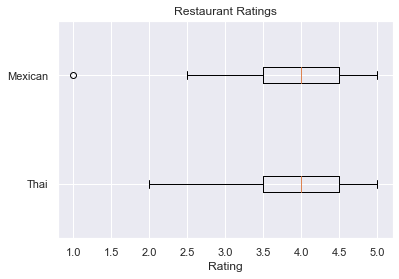

In [1137]:
fig, ax = plt.subplots()

# Add a boxplot for the "Height" column in the DataFrames
ax.boxplot([thaidf['Rating'], mexdf['Rating']], vert=False)
ax.set_title('Restaurant Ratings')

# Add x-axis tick labels:
ax.set_yticklabels(['Thai', "Mexican"])

# Add a y-axis label
ax.set_xlabel("Rating")

plt.savefig('RestRatingBoxPlot.jpg')


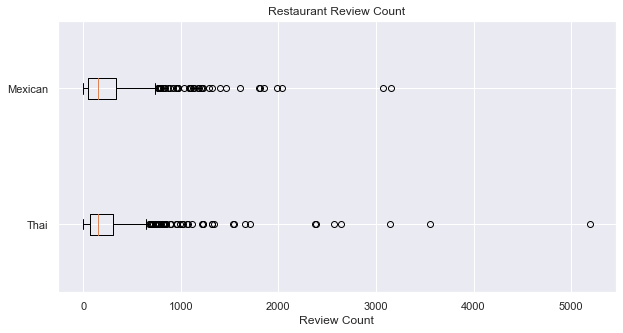

In [1121]:
fig, ax = plt.subplots(figsize=(10,5))

# Add a boxplot for the "Height" column in the DataFrames
ax.boxplot([thaidf['Review Count'], mexdf['Review Count']], vert=False)
ax.set_title('Restaurant Review Count')

# Add x-axis tick labels:
ax.set_yticklabels(['Thai', "Mexican"])

# Add a y-axis label
ax.set_xlabel("Review Count")

plt.show()

In [1120]:
thaidf['Review Count'] = thaidf['Review Count'].astype(int)
mexdf['Review Count'] = mexdf['Review Count'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, uazg6WhYVOw3jhWCG_MDBg to 60sLpAHHl-IvANGTRzfCow
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          1000 non-null   object 
 1   Location      996 non-null    object 
 2   Rating        1000 non-null   float64
 3   Price         804 non-null    string 
 4   Zipcode       1000 non-null   int64  
 5   Pickup        1000 non-null   object 
 6   Delivery      1000 non-null   object 
 7   Reservation   1000 non-null   object 
 8   Review Count  1000 non-null   int64  
 9   Categories    1000 non-null   object 
 10  Status        1000 non-null   object 
 11  type          1000 non-null   object 
dtypes: float64(1), int64(2), object(8), string(1)
memory usage: 101.6+ KB


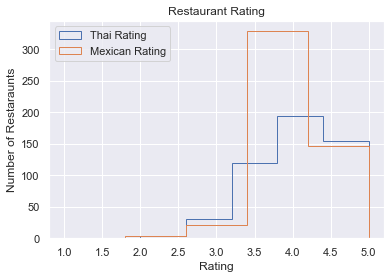

In [1136]:
fig, ax = plt.subplots()
# Plot a histogram of "Weight" for mens_rowing
ax.hist(thaidf['Rating'], label="Thai Rating", bins=5, histtype='step')

# Compare to histogram of "Weight" for mens_gymnastics
ax.hist(mexdf['Rating'], label="Mexican Rating", bins=5, histtype='step')

# Set the x-axis label to "Weight (kg)"
ax.set_xlabel('Rating')

# Set the y-axis label to "# of observations"
ax.set_ylabel('Number of Restaraunts')

ax.set_title('Restaurant Rating')

ax.legend(loc=2)

plt.savefig('RestRatingHist.jpg')

#showing a need for higher quality mexican restaurant

<ipython-input-1123-fea01e6faa0a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Thai', 'Mexican'], rotation=45)


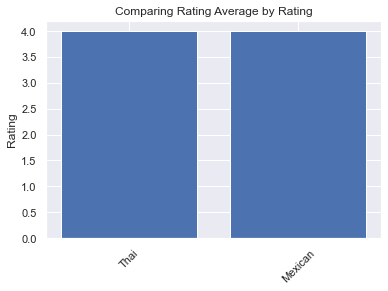

In [1123]:
#review count toal and rating mean
import statistics as stat
fig, ax = plt.subplots()

# Plot a bar-chart of gold medals as a function of country
ax.bar(['Thai', 'Mexican'], [stat.mode(thaidf['Rating']), stat.mode(mexdf['Rating'])])
# yerr= [males['Height'].std(), females['Height'].std()]

# Set the x-axis tick labels to the country names
ax.set_xticklabels(['Thai', 'Mexican'], rotation=45)

# Set the y-axis label
ax.set_ylabel("Rating")

ax.set_title('Comparing Rating Average by Rating')

plt.show()

<ipython-input-1124-5eac2fc03c22>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['Thai', 'Mexican'], rotation=45)


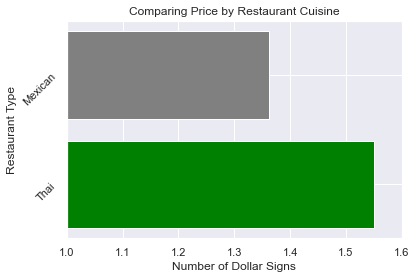

In [1124]:
#review count toal and rating mean
fig, ax = plt.subplots()

# Plot a bar-chart of gold medals as a function of country
ax.barh(['Thai', 'Mexican'], [thaidf['Price'].mean(), mexdf['Price'].mean()], color=('green','gray'))
# yerr= [males['Height'].std(), females['Height'].std()]

# Set the x-axis tick labels to the country names
ax.set_yticklabels(['Thai', 'Mexican'], rotation=45)

# Set the y-axis label
ax.set_xlabel('Number of Dollar Signs')
ax.set_ylabel("Restaurant Type")
ax.set_xlim(1,1.6)

ax.set_title('Comparing Price by Restaurant Cuisine')

plt.show()

<ipython-input-1125-50115318c464>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Thai', 'Mexican'], rotation=45)


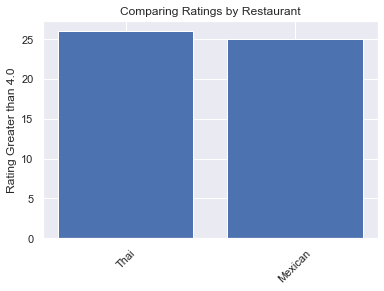

In [1125]:
#review count toal and rating mean
fig, ax = plt.subplots()

# Plot a bar-chart of gold medals as a function of country
ax.bar(['Thai', 'Mexican'], [thaidf[thaidf['Rating']==5].count()['Name'], mexdf[mexdf['Rating']==5].count()['Name']])
# yerr= [males['Height'].std(), females['Height'].std()]

# Set the x-axis tick labels to the country names
ax.set_xticklabels(['Thai', 'Mexican'], rotation=45)

# Set the y-axis label
ax.set_ylabel("Rating Greater than 4.0")

ax.set_title('Comparing Ratings by Restaurant')

plt.show()

<ipython-input-1149-1fb9951d6545>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Thai', 'Mexican'])


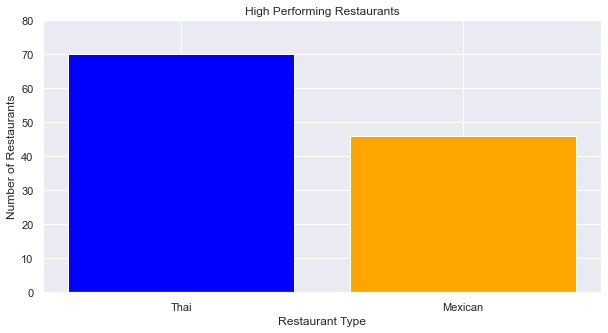

In [1149]:
#graphing ratings above 4 and review count above 100 for thai vs mex
top_rated=df[df['Rating']>=4.5]
top_rated=top_rated.sort_values('Review Count', ascending=False)
top_rated_and_reviews=top_rated[top_rated['Review Count']>=100]

high_mex = top_rated_and_reviews[top_rated_and_reviews['type']=='Mexican']
high_thai = top_rated_and_reviews[top_rated_and_reviews['type']=='Thai']

fig, ax = plt.subplots(figsize=(10,5))

# Plot a bar-chart 
ax.bar(['Thai', 'Mexican'], [high_thai.count()['Name'], high_mex.count()['Name']], color=('blue','orange'))

# Set the x-axis tick labels to the country names
ax.set_xticklabels(['Thai', 'Mexican'])

# Set the y-axis label
ax.set_xlabel('Restaurant Type')
ax.set_ylabel('Number of Restaurants')

ax.set_title('High Performing Restaurants')
ax.set_ylim(0,80)
# plt.tight_layout()

# plt.savefig('HighPerformingRest.jpg')
plt.show()


<ipython-input-1162-e2db9e6b8ea5>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['Thai', 'Mexican'])


Text(0.5, 1.0, 'High Performing Restaurants')

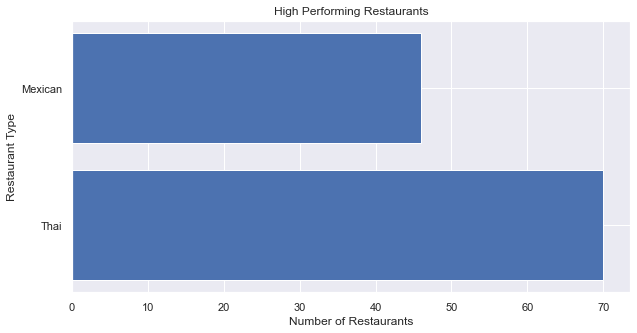

In [1162]:
fig, ax = plt.subplots(figsize=(10,5))

# Plot a bar-chart of gold medals as a function of country
ax.barh(['Thai', 'Mexican'], [high_thai.count()['Name'], high_mex.count()['Name']])
# yerr= [males['Height'].std(), females['Height'].std()]

# Set the x-axis tick labels to the country names
ax.set_yticklabels(['Thai', 'Mexican'])

# Set the y-axis label
ax.set_xlabel('Number of Restaurants')
ax.set_ylabel("Restaurant Type")
# ax.set_xlim(1,1.6)

ax.set_title('High Performing Restaurants')

# plt.savefig('HighPerformingResthorizontal.jpg')


In [1163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, uazg6WhYVOw3jhWCG_MDBg to 60sLpAHHl-IvANGTRzfCow
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          1000 non-null   object 
 1   Location      996 non-null    object 
 2   Rating        1000 non-null   float64
 3   Price         804 non-null    string 
 4   Zipcode       1000 non-null   object 
 5   Pickup        1000 non-null   object 
 6   Delivery      1000 non-null   object 
 7   Reservation   1000 non-null   object 
 8   Review Count  1000 non-null   int64  
 9   Categories    1000 non-null   object 
 10  Status        1000 non-null   object 
 11  type          1000 non-null   object 
dtypes: float64(1), int64(1), object(9), string(1)
memory usage: 101.6+ KB


In [1128]:
# thai_sorted=0
# mex_sorted=0
# sorted_vals = df.sort_values('Review Count',ascending=False)[0:25]
# if sorted_vals.index.isin(mexdf['Id']):
#     mex_sorted+=1  
# zero_filled_number = number_str.zfill(5) 

df['Zipcode'] = df['Zipcode'].map( lambda x : str(x).zfill(5))

<ipython-input-1128-1636735854af>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Zipcode'] = df['Zipcode'].map( lambda x : str(x).zfill(5))


In [1129]:
# zipx = zipy.index
# zipy = df.groupby('Zipcode').count()['Name']

# fig,ax=plt.subplots(figsize=(20,20))
# plt.barh(zipx,zipy)

In [1130]:
fp = '/Users/anishamalhotra/Downloads/zip_code_040114.geojson'

<AxesSubplot:>

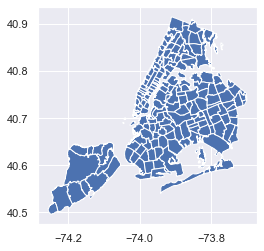

In [1131]:
map_df=gpd.read_file(fp)
map_df.plot()

In [952]:
merged['Zipcode'].unique()

array([nan], dtype=object)

In [950]:
map_df
merged = map_df.set_index('ZIPCODE').join(df.set_index('Zipcode'))

KeyError: "None of [Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,\n            ...\n            253, 254, 255, 256, 257, 258, 259, 260, 261, 262],\n           dtype='int64', length=263)] are in the [columns]"

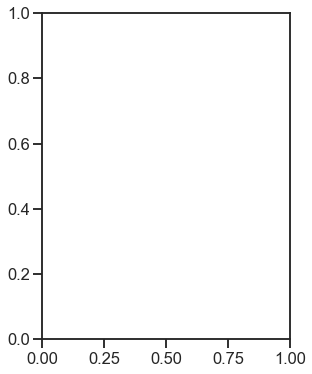

In [953]:
variable = merged.index.unique()
vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=merged.index, cmap='Blue', linewidth=0.8, ax=ax, edgecolor='0.8')

___

# Reference help

###  Pagination

Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retriving 50 at a time. Processes such as these are often refered to as pagination.

Now that you have an initial response, you can examine the contents of the json container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. 

**Note: be mindful of the API rate limits. You can only make 5000 requests per day, and APIs can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

***Below is sample code that you can use to help you deal with the pagination parameter and bring all of the functions together.***


***Also, something might cause your code to break while it is running. You don't want to constantly repull the same data when this happens, so you should insert the data into the database as you call and parse it, not after you have all of the data***


In [ ]:
# create a variable  to keep track of which result you are in. 
cur = 0

#set up a while loop to go through and grab the result 
while cur < num and cur < 1000:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = cur
    #make your API call with the new offset number
    results = yelp_call(url_params, api_key)
    
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results(results)
    
    # use your function to insert your parsed results into the db
    db_insert(parsed_results)
    #increment the counter by 50 to move on to the next results
    cur += 20